# Pipeline for automatically cutting a video using the proposed model

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import cv2
from PIL import Image
from IPython.display import clear_output
from IPython.display import Image as IPImage
import os
import glob
import datetime

## Loding the trained model weights

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('cricket1.pth')
model.eval()

A function defined for predicting probability of a frame being play

In [3]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    inp = Variable(image_tensor)
    inp = inp.to(device)
    outp = model(inp)
    index = outp.data.cpu().numpy().argmax()
    res = outp.data.cpu().numpy()[0]
    ratio= res[0]/sum(res)
    return ratio

### Insert input video path here

In [6]:
videopath = 'ashes_cut.mp4'
test_transforms = transforms.Compose([transforms.Resize([224,224]),
                                      transforms.ToTensor(),
                                     ])
# initialize Sort object and video capture
vid = cv2.VideoCapture(videopath)
fps = vid.get(cv2.CAP_PROP_FPS)
print('The video is shot at ' + str(int(fps)) + 'fps')

The video is shot at 25fps


### Here we are predicting the probability for each frame

In [ ]:
pred_array=[]
counter=0

read_flag, frame = vid.read()

while read_flag:  
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(frame,100,200)
    pilimage = Image.fromarray(edges)
    pred = predict_image(pilimage.convert("RGB"))
    pred_array.append(pred)
    counter=counter+1
    read_flag, frame = vid.read()
    print(pred)
    if pred>0.2:
        display(pilimage)
    if counter%(fps*60)==0:
        print("Min:",counter/(fps*60))

### Moving average is calculated to make the graph look pretty

In [29]:
mov_avg = []
for i in range(len(pred_array)):
    try:
        mov_avg.append(sum(pred_array[i-30:i+30])/60)
    except:
        pass

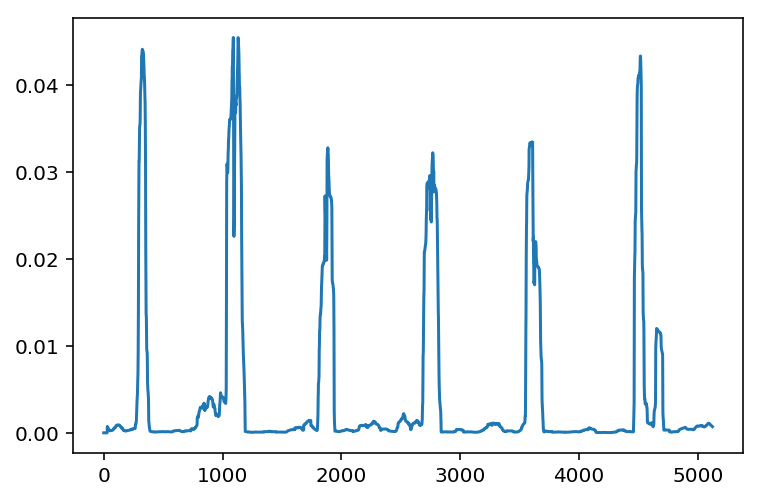

In [30]:
plt.plot(mov_avg)

### Scipt Signal package is used to find the peaks. This is the start time (in secs) of the delivery stride

In [34]:
import scipy.signal
cues=scipy.signal.find_peaks(np.array(mov_avg), height=0.02,distance=250)[0]
cues = [round((i*1.0)/fps,2) for i in cues]
cues

[13.0, 43.64, 75.44, 110.76, 144.36, 180.68]

### Using ffmpeg package to cut the video splits based on above timestamps

In [28]:
os.system('rm -r temp/')
os.system('mkdir temp')
f= open("templist.txt","w+")
counter=0
for cue in cues:
    counter=counter+1
    timestamp = str(datetime.timedelta(seconds=cue-1))[:10]
    print(timestamp)
    os.system('ffmpeg -i '+videopath+' -ss '+timestamp+' -t 00:00:06 -strict -2 temp/'+str(counter)+'.mp4')
    f.write("file "+"'temp/"+str(counter)+".mp4"+"'\n")
f.close()

0:00:12
0:00:42.64
0:01:14.44
0:01:49.76
0:02:23.36
0:02:59.68


In [59]:
!head templist.txt

file 'temp/1.mp4'
file 'temp/2.mp4'
file 'temp/3.mp4'
file 'temp/4.mp4'
file 'temp/5.mp4'
file 'temp/6.mp4'


### Finally, concatenating the video splits to get the final cut

In [60]:
path = videopath.split('.')[0]+'highlights.mp4'
os.system('rm -rf ' + path)
os.system('ffmpeg -f concat -i templist.txt -c copy '+ path)

0